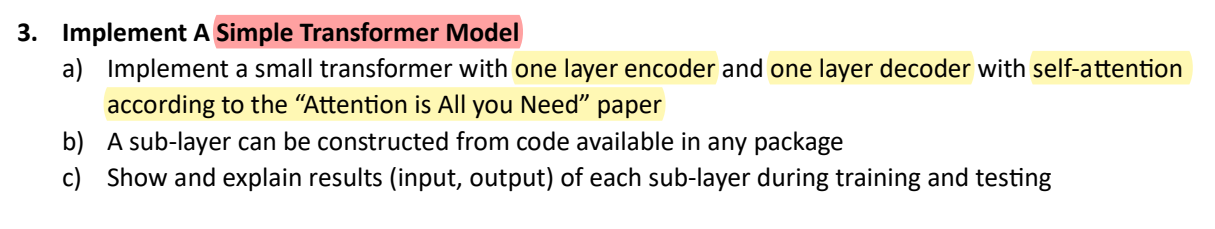

# Miro Code Chart

https://miro.com/app/board/uXjVMCPUI4Y=/?share_link_id=574580340549

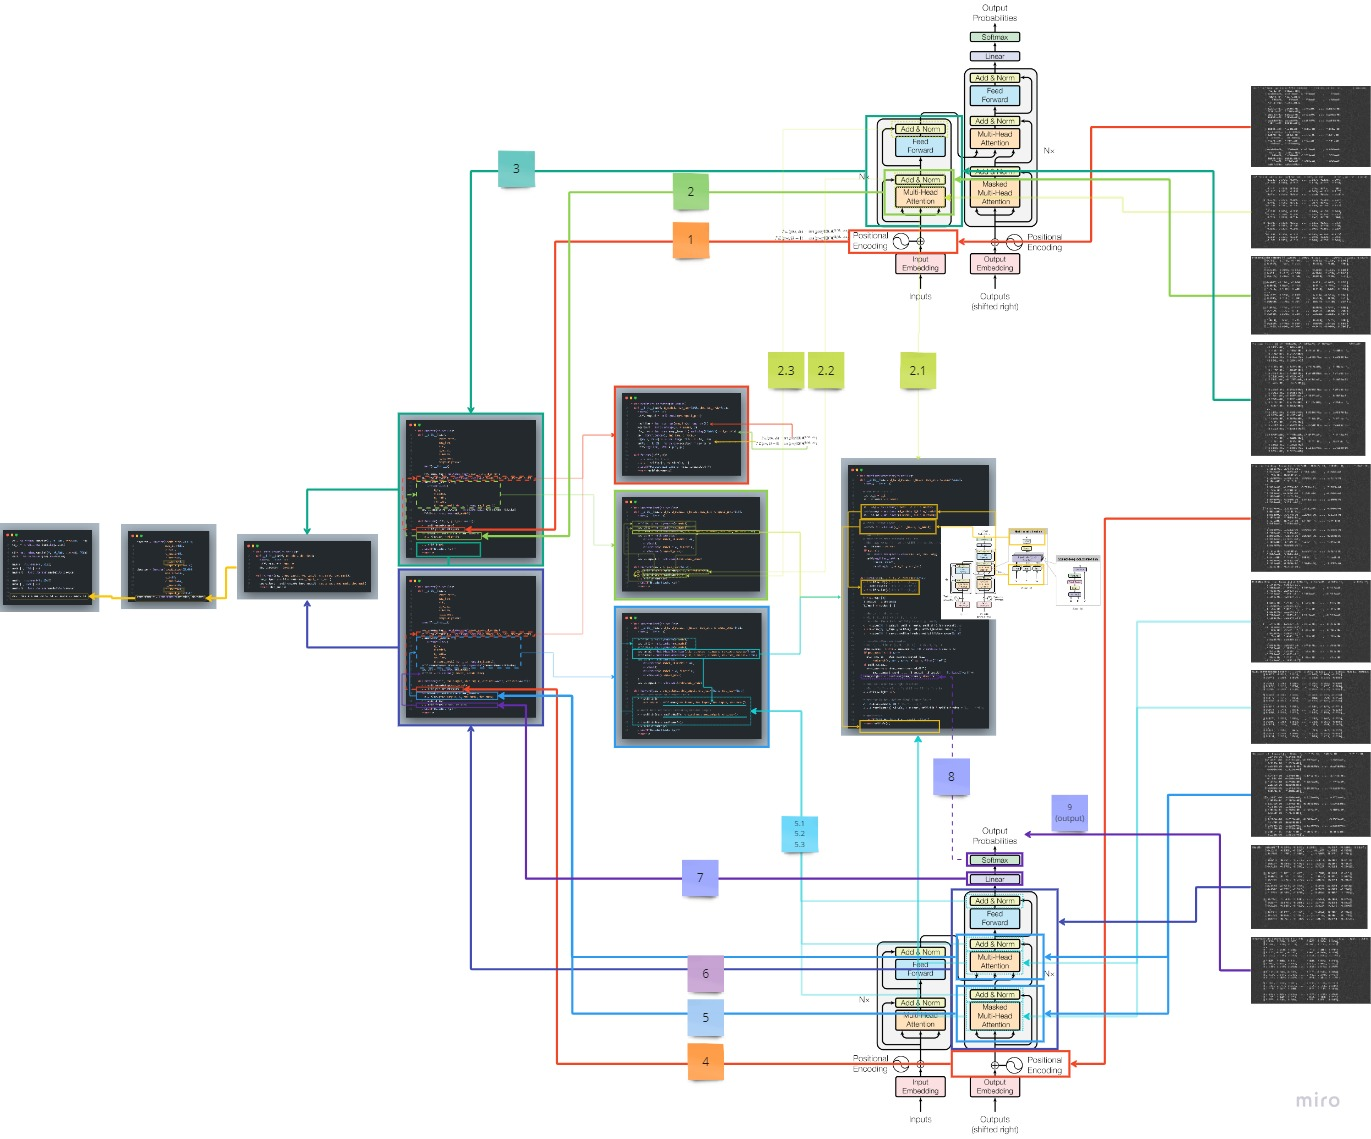

# Coding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os

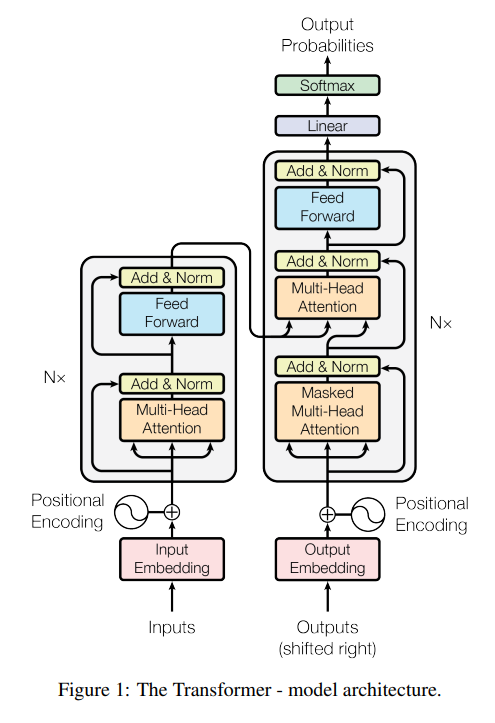





## Define PyTorch module MultiHeadAttention which represents multi-head self attention mechanism in a transformer model

The MultiHeadAttention module encapsulates the operations required for performing multi-head self-attention in a transformer model. It takes query, key, and value tensors as inputs and produces an output tensor after applying attention and projection operations.

**__init__ method:** initialize the MultiHeadAttention module. 
> It takes input arguments
*   d_k (dimension of each head)
*   d_model (input dimension)
*   n_heads (number of attention heads)
*   max_len (maximum sequence length)
*   causal (a boolean flag indicating whether to apply a causal mask)

It initializes the parameters of the attention mechanism, including linear layers for key, query, and value projections, and a linear layer for the final output projection. If causal is True, it also creates a causal mask to prevent attending to future positions.


**forward method:** define the forward pass of the MultiHeadAttention module. 
> It takes three inputs representing the input to the attention mechanism
*   q (query)
*   k (key)
*   v (value) tensors
Additionally, there is an optional pad_mask tensor to mask out padded positions.

> The method performs linear transformations on q, k, and v tensors using separate linear layers.

> The shape of the tensors is then modified to (N, T, h, d_k) to facilitate matrix multiplication.
*   N represents the batch size
*   T represents the sequence length
*   h represents the number of attention heads
*   d_k represents the dimension of each head

> Attention scores are computed by performing matrix multiplication between query and key tensors, followed by scaling by the square root of d_k. If a pad_mask is provided, attention scores for padded positions are set to -inf to mask them out. If causal is True, attention scores for future positions are also set to -inf.

> Attention weights are obtained by applying softmax along the last dimension of the attention scores.

> Attention-weighted values are computed by multiplying the attention weights with the value tensor.

> The attention-weighted values are reshaped and concatenated along the head dimension, resulting in a tensor of shape (N, T, h * d_k).

> Finally, the concatenated tensor is passed through the final linear layer and returned as the output. The output is also printed and saved in a text file for debugging purposes.



In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
    super().__init__()

    # Assume d_v = d_k
    self.d_k = d_k
    self.n_heads = n_heads

    self.key = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)

    # final linear layer
    self.fc = nn.Linear(d_k * n_heads, d_model)

    # causal mask
    # make it so that diagonal is 0 too
    # this way we don't have to shift the inputs to make targets
    self.causal = causal
    if causal:
      cm = torch.tril(torch.ones(max_len, max_len))
      self.register_buffer(
          "causal_mask",
          cm.view(1, 1, max_len, max_len)
      )

  def forward(self, q, k, v, pad_mask=None):
    q = self.query(q) # N x T x (hd_k)
    k = self.key(k)   # N x T x (hd_k)
    v = self.value(v) # N x T x (hd_v)

    N = q.shape[0]
    T_output = q.shape[1]
    T_input = k.shape[1]

    # change the shape to:
    # (N, T, h, d_k) -> (N, h, T, d_k)
    # in order for matrix multiply to work properly
    q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

    # compute attention weights
    # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    if pad_mask is not None:
      attn_scores = attn_scores.masked_fill(
          pad_mask[:, None, None, :] == 0, float('-inf'))
    if self.causal:
      attn_scores = attn_scores.masked_fill(
          self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim=-1)
    
    # compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1, 2) # (N, T, h, d_k)
    A = A.contiguous().view(N, T_output, self.d_k * self.n_heads) # (N, T, h*d_k)

    # projection
    print(f"MultiHeadAttention: {self.fc(A)}")

    file_name = 'MultiHeadAttention.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(self.fc(A)))
        file.write('\n') 
    
    return self.fc(A)

# Define PyTorch module EncoderBlock represents a single block or layer of the encoder component in a transformer model.

EncoderBlock module defines the operations and transformations performed within a single block or layer of the encoder component in a transformer model. It combines self-attention, feed-forward neural networks, and residual connections to capture and transform the input seequence.

**__init__ method:** responsible for initializing the EncoderBlock module. 
> It takes input arguments 
*   d_k (dimension of each attention head)
*   d_model (input dimension)
*   n_heads (number of attention heads)
*   max_len (maximum sequence length)
*   dropout_prob (dropout probability)

The method does the followings:
*   creates two layer normalization layers (ln1 and ln2) to normalize the input and output of the attention and feed-forward layers.
*   creates a MultiHeadAttention module (mha) with the given d_k, d_model, n_heads, max_len, and causal=False parameters. This module represents the self-attention mechanism used in the encoder block.
*  creates an artificial neural network (ann) using the nn.Sequential container. This network consists of two linear layers with ReLU activation and a dropout layer. It is applied after the self-attention layer to introduce non-linearity and regularization.
*   creates a dropout layer (dropout) with the specified dropout probability.

**forward method:** defines the forward pass of the EncoderBlock module. 
> It takes inputs
*   input tensor x
*   optional pad_mask tensor

The method applies layer normalization (ln1) to the input tensor and adds it to the output of the self-attention mechanism (mha) applied to the same input tensor. This residual connection is used to capture important information from the input and the attention mechanism.

The result is then passed through the second layer normalization (ln2) and added to the output of the artificial neural network (ann) applied to the same tensor. This again utilizes a residual connection to combine the attention and feed-forward components.

The output tensor is then passed through the dropout layer for regularization.

The output tensor is also printed and saved in a text file for debugging purposes.

Finally, the output tensor is returned as the output of the EncoderBlock.


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.ReLU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)
  
  def forward(self, x, pad_mask=None):
    x = self.ln1(x + self.mha(x, x, x, pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)

    print(f"EncoderBlock: {x}")

    file_name = 'EncoderBlock.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(x))
        file.write('\n') 
            
    return x

# Define a PyTorch module DecoderBlock represents a single block or layer of the decoder component in a transformer model.

The DecoderBlock module defines the operations and transformations performed within a single block or layer of the decoder component in a transformer model. It combines self-attention, attention to the encoder output, feed-forward neural networks, and residual connections to capture and transform the input sequence during decoding.

**__init__ method:** responsible for initializing the DecoderBlock module. 
> It takes several input arguments similar to EncoderBlock.

It does the followings:
*   creates three layer normalization layers (ln1, ln2, and ln3) to normalize the input and output of the attention and feed-forward layers.
*   creates two MultiHeadAttention modules (mha1 and mha2). mha1 represents the self-attention mechanism applied to the decoder input, and mha2 represents the attention mechanism that combines information from both the decoder input and the encoder output.
*   creates an artificial neural network (ann) using the nn.Sequential container. This network consists of two linear layers with ReLU activation and a dropout layer. It is applied after the second attention mechanism to introduce non-linearity and regularization.
*  creates a dropout layer (dropout) with the specified dropout probability.

**forward method:** defines the forward pass of the DecoderBlock module.
> It takes four input tensors:
*   enc_output (output of the encoder)
*   dec_input (input to the decoder)
*   enc_mask (mask for the encoder output)
*   dec_mask (mask for the decoder input)

The method applies layer normalization (ln1) to the decoder input and adds it to the output of the self-attention mechanism (mha1) applied to the same input. This residual connection captures important information from the decoder input and the self-attention mechanism.

The result is then passed through the second layer normalization (ln2) and added to the output of the attention mechanism (mha2) applied to the same tensor. The attention mechanism combines information from the decoder input and the encoder output using the provided masks. This step allows the decoder to attend to relevant parts of the encoder output during decoding.

The output of the attention mechanism is passed through the third layer normalization (ln3) and added to the output of the artificial neural network (ann) applied to the same tensor. This again utilizes a residual connection to combine the attention and feed-forward components.

The output tensor is then passed through the dropout layer for regularization.

The output tensor is also printed and saved in a text file for debugging purposes.

Finally, the output tensor is returned as the output of the DecoderBlock.


In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)
    self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
    self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.ReLU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)
  
  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    # self-attention on decoder input
    x = self.ln1(
        dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))

    # multi-head attention including encoder output
    x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))

    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)

    print(f"DecoderBlock: {x}")

    file_name = 'DecoderBlock.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(x))
        file.write('\n')     
    
    return x

# Define a PyTorch module PositionalEncoding used to add positional encoding to the input sequences in a transformer model.

The PositionalEncoding module calculates and adds positional encoding to the input sequences in a transformer model. The positional encoding provides information about the position or order of tokens in the input sequence, allowing the transformer model to capture sequential information.

**__init__ method:** responsible for initializing the PositionalEncoding module.

> It takes several input arguments
*   d_model (input dimension)
*   max_len (maximum sequence length)
*   dropout_prob (dropout probability)

The method initializes a dropout layer (dropout) with the specified dropout probability.

It does the followings:
*   calculates the positional encoding values using sine and cosine functions.
*   creates a position tensor (position) with values from 0 to max_len-1 and an exponential term tensor (exp_term) with values from 0 to d_model-1 incrementing by 2.
*   calculates a divisor tensor (div_term) using these values to scale the sine and cosine functions.
*   creates a positional encoding tensor (pe) of shape (1, max_len, d_model) and fills it with zeros. The odd and even dimensions of the tensor are filled with the calculated sine and cosine values, respectively.

The positional encoding tensor (pe) is registered as a buffer in the module using self.register_buffer. Buffers are persistent tensors that are part of the module's state but are not considered as model parameters.

**forward method:** defines the forward pass of the PositionalEncoding module. 

> It takes an input tensor x as input.

The method adds the positional encoding tensor (pe) to the input tensor x. The positional encoding tensor is sliced to match the length of the input sequence. This operation is performed by self.pe[:, :x.size(1), :], where :x.size(1) ensures that the positional encoding tensor has the same length as the input sequence.

The result is passed through the dropout layer for regularization.

The output tensor is then printed and saved in a text file for debugging purposes.

Finally, the output tensor is returned as the output of the PositionalEncoding module.


In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    # x.shape: N x T x D
    x = x + self.pe[:, :x.size(1), :]

    print(f"PositionalEncoding: {self.dropout(x)}")

    file_name = 'PositionalEncoding.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(self.dropout(x)))
        file.write('\n')  
        
    return self.dropout(x)

# Define a PyTorch module Encoder, which represents the encoder component of a transformer model.

The Encoder module performs the encoding step in a transformer model. It takes an input sequence, applies embedding and positional encoding, and passes the sequence through multiple encoder blocks to capture contextual information. The output of the encoder can then be used as input to the decoder or further processed for downstream tasks.

**__init__ method:** responsible for initializing the Encoder module. 
> It takes several input arguments
*   vocab_size (vocabulary size)
*   max_len (maximum sequence length)
*   d_k (dimension of key/query/value in self-attention)
*   d_model (input dimension)
*   n_heads (number of attention heads)
*   n_layers (number of encoder blocks)
*   dropout_prob (dropout probability)

The method initializes an embedding layer (embedding) with the specified vocabulary size and input dimension.

It does the followings:
*   creates a positional encoding module (pos_encoding) using the PositionalEncoding class, which adds positional encoding to the input sequences.
*   creates a sequence of encoder blocks (transformer_blocks) by instantiating the EncoderBlock class n_layers times. These encoder blocks will process the input sequence in a stacked manner.
*   initializes a layer normalization module (ln) with the input dimension. Layer normalization is applied after the transformer blocks.

Optionally, a fully connected layer (fc) can be added to the output of the encoder to map it to a specific number of output classes. However, this part is currently commented out in the code.

**forward method:** defines the forward pass of the Encoder module. 
> It takes:
*   input tensor x representing the input sequence
*   an optional padding mask tensor pad_mask

The input tensor x is passed through the embedding layer to obtain the embedded representation of the input sequence.

The embedded representation is then passed through the positional encoding module (pos_encoding) to add positional information to the sequence.

The resulting tensor is then passed through the sequence of transformer blocks (transformer_blocks) in a sequential manner. Each transformer block processes the input tensor and produces an updated representation.

After processing through the transformer blocks, the output tensor is passed through layer normalization (ln).

The output tensor is printed and saved in a text file for debugging purposes.

Finally, the output tensor is returned as the output of the Encoder module.

In [ ]:
class Encoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
              #  n_classes,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        EncoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    # self.fc = nn.Linear(d_model, n_classes)
  
  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)

    # many-to-one (x has the shape N x T x D)
    # x = x[:, 0, :]

    x = self.ln(x)
    # x = self.fc(x)

    print(f"Encoder: {x}")

    file_name = 'Encoder.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(x))
        file.write('\n')
        
    return x

# Define PyTorch module Decoder, which represents the decoder component of a transformer model.

The Decoder module performs the decoding step in a transformer model. It takes the output of the encoder, processes the decoder input sequence by applying embedding and positional encoding, and passes it through multiple decoder blocks to generate the predicted output tokens. The output of the decoder can be used for sequence generation or further processed for specific tasks.

**__init__ method:** This method is responsible for initializing the Decoder module. It takes several input arguments such as vocab_size (vocabulary size), max_len (maximum sequence length), d_k (dimension of key/query/value in self-attention), d_model (input dimension), n_heads (number of attention heads), n_layers (number of decoder blocks), dropout_prob (dropout probability).

The method initializes an embedding layer (embedding) with the specified vocabulary size and input dimension.

It does the followings:

*   creates a positional encoding module (pos_encoding) using the PositionalEncoding class, which adds positional encoding to the input sequences.
*   creates a sequence of decoder blocks (transformer_blocks) by instantiating the DecoderBlock class n_layers times. These decoder blocks will process the input sequence and the output of the encoder in a stacked manner.
*   initializes a layer normalization module (ln) with the input dimension. Layer normalization is applied after the transformer blocks.
*   initializes a fully connected layer (fc) that maps the output dimension of the decoder to the vocabulary size. This layer is responsible for generating the predicted output tokens.

**forward method:** defines the forward pass of the Decoder module. 
> It takes four input tensors:
*   enc_output (output of the encoder)
*   dec_input (input to the decoder)
*   enc_mask (mask for encoder output)
*   dec_mask (mask for decoder input)

The input tensor dec_input is passed through the embedding layer to obtain the embedded representation of the decoder input sequence.

The embedded representation is then passed through the positional encoding module (pos_encoding) to add positional information to the decoder input sequence.

The resulting tensor is then passed through the sequence of decoder blocks (transformer_blocks) in a sequential manner. Each decoder block processes the input tensor and produces an updated representation by attending to the encoder output.

After processing through the transformer blocks, the output tensor is passed through layer normalization (ln).

The output tensor is passed through the fully connected layer (fc) to generate the predicted output tokens. This corresponds to a many-to-many mapping, where each input token is mapped to a predicted output token.

The output tensor is printed and saved in a text file for debugging purposes.

Finally, the output tensor is returned as the output of the Decoder module.

In [ ]:
class Decoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        DecoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)
  
  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    x = self.embedding(dec_input)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(enc_output, x, enc_mask, dec_mask)
    x = self.ln(x)
    x = self.fc(x) # many-to-many

    print(f"Decoder: {x}")

    file_name = 'Decoder.txt'
    file_path = f'/content/{file_name}'
    with open(file_path, 'a') as file:
        file.write(str(x))
        file.write('\n')
            
    return x

# Define PyTorch module Transformer, which represents a complete transformer model consisting of an encoder and a decoder.

The Transformer module encapsulates the entire transformer model by combining the encoder and decoder components. It performs the complete transformation of the input sequence, from encoding the input using the encoder to decoding the output using the decoder. The forward method orchestrates the flow of data through the encoder and decoder and returns the final output of the transformer model.

**__init__ method:** initializes the Transformer module. 
> It takes two input arguments: encoder and decoder, which are instances of the encoder and decoder modules. These modules are passed as arguments when creating an instance of the Transformer class.

**forward method:** defines the forward pass of the Transformer module. 
> It takes four input tensors:
*   enc_input (input to the encoder)
*   dec_input (input to the decoder)
*   enc_mask (mask for encoder input)
*   dec_mask (mask for decoder input)

The enc_input and enc_mask tensors are passed through the encoder module (self.encoder) to obtain the encoder output (enc_output).

The enc_output, along with dec_input and the masks, is passed through the decoder module (self.decoder) to obtain the decoder output (dec_output).

The decoder output is printed and saved in a text file for debugging purposes.

Finally, the decoder output is returned as the output of the Transformer module.


In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    
    print(f"Transformer-dec_output: {dec_output}")
    file_name = 'Transformer.txt'
    file_path = f'/content/{file_name}'
    
    with open(file_path, 'a') as file:
        file.write(str(dec_output))
        file.write('\n')    
    
    return dec_output

# Define and configure Encoder, Decoder and Transforer components of a transformer model.

In [ ]:
encoder = Encoder(vocab_size=20_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=1,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=10_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=1,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

# Device allocation for the encoder and decoder objects in a PyTorch-based transformer model for efficient computation and parameter storage.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (embedding): Embedding(10000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

# New Section

# Test

In [ ]:
xe = np.random.randint(0, 20_000, size=(8, 512))
xe_t = torch.tensor(xe).to(device)

xd = np.random.randint(0, 10_000, size=(8, 256))
xd_t = torch.tensor(xd).to(device)

maske = np.ones((8, 512))
maske[:, 256:] = 0
maske_t = torch.tensor(maske).to(device)

maskd = np.ones((8, 256))
maskd[:, 128:] = 0
maskd_t = torch.tensor(maskd).to(device)

out = transformer(xe_t, xd_t, maske_t, maskd_t)


PositionalEncoding: tensor([[[ 1.4889,  1.5308,  1.4906,  ...,  1.2534, -1.4294,  2.4552],
         [ 0.0039,  0.8644, -0.5312,  ...,  2.1635, -0.2878,  0.0063],
         [ 0.8046, -0.7554,  0.8755,  ...,  2.2907, -0.8095,  0.8223],
         ...,
         [ 1.7568, -0.4320, -0.8885,  ...,  0.7333,  0.6718, -0.4050],
         [-0.8428,  0.7432, -0.4949,  ...,  1.3253,  1.2243,  1.5386],
         [ 1.8658,  0.3371, -0.8892,  ...,  1.5182, -0.6804,  0.5862]],

        [[-0.6667,  1.0287, -0.5290,  ...,  0.5924,  0.0631,  1.3388],
         [-1.7820, -0.3026,  2.4279,  ..., -0.3480, -0.7353,  0.5861],
         [ 0.8557,  0.7098, -1.3780,  ..., -0.8046, -1.5302,  1.5591],
         ...,
         [-0.9584,  1.2798,  0.0903,  ..., -0.9221, -1.1710,  0.4366],
         [ 1.3007,  1.0159,  0.3734,  ..., -0.8761, -0.8051,  1.1766],
         [ 1.4295, -0.1990, -0.7952,  ...,  2.4110,  0.0529, -0.4794]],

        [[ 0.6988,  0.4944,  0.0947,  ...,  1.5285,  0.0926, -0.3372],
         [ 1.5172,  1.663

In [ ]:
out.shape

torch.Size([8, 256, 65002])

In [ ]:
out

tensor([[[  5.4736, -21.2276,   7.9706,  ..., -19.7246, -20.7578, -20.3813],
         [ 13.5170, -19.9524,   6.0349,  ..., -15.6716, -17.8130, -17.0110],
         [ -1.3729, -19.0096,   6.5334,  ..., -17.8480, -18.9244, -18.0692],
         ...,
         [ -2.0905, -17.2011,   7.4308,  ..., -15.9542, -16.6001, -16.1908],
         [  1.3383, -13.0079,   4.3420,  ..., -11.1063, -10.9374, -10.6242],
         [ -2.8584, -19.2458,   6.5053,  ..., -17.7230, -17.7691, -17.8282]],

        [[  0.7280, -18.5738,  10.0986,  ..., -17.5426, -17.4153, -17.5668],
         [ -1.2433, -14.7468,   4.4429,  ..., -14.0870, -16.1041, -14.8518],
         [  2.8829, -20.7391,   7.6862,  ..., -17.9553, -19.7403, -19.0549],
         ...,
         [  1.7038, -14.7389,   6.9933,  ..., -14.4746, -14.3893, -13.1168],
         [ -3.4827, -17.5211,   8.1433,  ..., -16.7259, -18.3848, -16.9939],
         [ -0.2312, -20.8917,   4.9080,  ..., -19.5330, -19.4346, -20.6078]],

        [[  0.7900, -17.9742,   5.2049,  ...

# Translation

# Download and extract a zip file containing translation data (Spanish-English) for training a machine translation model.

In [ ]:
# Download the file
url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
path_to_zip, _ = urllib.request.urlretrieve(url, filename='spa-eng.zip')
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall()

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"


In [ ]:
!head spa.txt

head: cannot open 'spa.txt' for reading: No such file or directory


In [ ]:
import pandas as pd
df = pd.read_csv('/content/spa-eng/spa.txt', sep="\t", header=None)

In [ ]:
df.shape

(118964, 2)

In [ ]:
df = df.iloc[:30_000] # takes too long

In [ ]:
df.columns = ['en', 'es']
df.to_csv('spa.csv', index=None)

In [ ]:
!head spa.csv

en,es
Go.,Ve.
Go.,Vete.
Go.,Vaya.
Go.,Váyase.
Hi.,Hola.
Run!,¡Corre!
Run.,Corred.
Who?,¿Quién?
Fire!,¡Fuego!


In [ ]:
!pip install transformers datasets sentencepiece sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 71.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB

In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='spa.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-702abaa8b3c635a0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 30000
    })
})

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 9000
    })
})

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
en_sentence = split["train"][0]["en"]
es_sentence = split["train"][0]["es"]

inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)

tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁¿', 'Quién', '▁viene', '?', '</s>']

In [ ]:
es_sentence

'¿Quién viene?'

In [ ]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch['en'], max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    labels = tokenizer(
        text_target=batch['es'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split["train"].column_names,
)

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
})

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
batch['input_ids']

tensor([[ 1737,    20,   210,   464,    21,     0, 65000, 65000],
        [   33,  3210,    27,    59,  5266,     3,     0, 65000],
        [   33,    20,    92,   450,    16, 15980,     3,     0],
        [ 2070,    53,    83, 13515,     3,     0, 65000, 65000],
        [  552,  2576,    74,     8,   113,   210,     3,     0]])

In [ ]:
batch['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
batch['labels']

tensor([[   50,  2699,  3662,    21,     0,  -100,  -100,  -100],
        [17270,    15,    26, 14561,     4,  5266,     3,     0],
        [ 1686,     4,  4501,    12, 15980,     3,     0,  -100],
        [  160,   293,  1209, 18315,     3,     0,  -100,  -100],
        [ 2722,    74,  2918,    38, 22050,     3,     0,  -100]])

In [ ]:
tokenizer.all_special_ids

[0, 1, 65000]

In [ ]:
tokenizer('<pad>')

{'input_ids': [65000, 0], 'attention_mask': [1, 1]}

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32,
    collate_fn=data_collator
)

In [ ]:
# check how it works
for batch in train_loader:
  for k, v in batch.items():
    print("k:", k, "v.shape:", v.shape)
  break

k: input_ids v.shape: torch.Size([32, 9])
k: attention_mask v.shape: torch.Size([32, 9])
k: labels v.shape: torch.Size([32, 8])


In [ ]:
tokenizer.vocab_size

65001

In [ ]:
tokenizer.decode([60000])

'ѕэр'

In [ ]:
tokenizer.add_special_tokens({"cls_token": "<s>"})

1

In [ ]:
tokenizer("<s>")

{'input_ids': [65001, 0], 'attention_mask': [1, 1]}

In [ ]:
tokenizer.vocab_size

65001

In [ ]:
encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=1,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=1,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (embedding): Embedding(65002, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())

In [ ]:
from datetime import datetime
# A function to encapsulate the training loop
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for batch in train_loader:
      # move data to GPU (enc_input, enc_mask, translation)
      batch = {k: v.to(device) for k, v in batch.items()}

      # zero the parameter gradients
      optimizer.zero_grad()

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets forwards to get decoder_input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 65_001

      # also convert all -100 to pad token id
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      # Forward pass
      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for batch in valid_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      # shift targets forwards to get decoder_input
      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 65_001

      # change -100s to regular padding
      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id)

      # make decoder input mask
      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = train(transformer, criterion, optimizer, train_loader, valid_loader, epochs=15)

Streaming output truncated to the last 5000 lines.
         [  0.1242, -18.3446,   2.7781,  ..., -17.4022, -18.1356, -17.5902]],

        ...,

        [[  0.5386, -16.2741,   3.1150,  ..., -13.2919, -14.5533, -14.8177],
         [ -5.8379, -13.5277,   2.3755,  ..., -12.0255, -13.0910, -12.7252],
         [ -7.1019,  -9.7470,   3.0578,  ...,  -8.5821,  -9.6432,  -9.4820],
         ...,
         [  0.4238,  -5.6088,  -0.3391,  ...,  -4.4402,  -4.4053,  -5.2593],
         [  4.1636, -24.8478,   6.1152,  ..., -21.2547, -23.3767, -23.4315],
         [ 23.1401, -18.5083,   4.4631,  ..., -14.7326, -16.0077, -15.7201]],

        [[  5.7226, -12.1530,  -0.3410,  ...,  -8.9703, -12.0352, -11.6324],
         [  0.1288, -17.9968,   2.5416,  ..., -16.2756, -19.0342, -17.4644],
         [ -3.7462, -11.9239,   0.8860,  ..., -10.9012, -13.3396, -11.8623],
         ...,
         [  1.5389, -16.8535,  -0.3326,  ..., -15.8449, -17.4843, -16.1279],
         [  1.9014, -16.7841,  -0.4661,  ..., -15.6051, 

In [ ]:
# try it out

input_sentence = split['test'][10]['en']
input_sentence

'Tom and Mary hugged.'

In [ ]:
enc_input = tokenizer(input_sentence, return_tensors='pt')
enc_input

{'input_ids': tensor([[ 5266,    10,  4963, 29399, 12628,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
dec_input_str = '<s>'

dec_input = tokenizer(text_target=dec_input_str, return_tensors='pt')
dec_input

# We'll ignore the final 0 ( </s> )

{'input_ids': tensor([[65001,     0]]), 'attention_mask': tensor([[1, 1]])}

In [ ]:
enc_input.to(device)
dec_input.to(device)
output = transformer(
    enc_input['input_ids'],
    dec_input['input_ids'][:, :-1],
    enc_input['attention_mask'],
    dec_input['attention_mask'][:, :-1],
)
output

PositionalEncoding: tensor([[[-1.5063e-01,  1.5009e+00, -1.1336e-01,  7.8952e-01,  5.0587e-01,
           3.6185e-01, -5.1793e-02,  2.5769e+00,  7.9401e-01,  9.7890e-01,
           4.3208e-01, -1.0325e+00,  1.9613e-01,  8.4160e-01, -8.0806e-02,
          -1.2029e-01,  1.3478e+00,  9.8365e-01,  8.3027e-01, -4.4906e-01,
          -2.2704e+00, -1.1974e-01, -2.1143e+00,  2.8651e-01,  8.1089e-01,
          -2.8620e-01, -2.7398e-01, -2.7922e-01, -2.2991e-01,  1.5504e-01,
           5.0619e-01,  1.2515e+00,  3.2033e-01,  5.8439e-01, -5.4450e-01,
           1.8904e+00,  5.1425e-01,  2.8986e-01,  1.5933e+00,  8.2381e-02,
          -6.7906e-01,  1.2531e+00, -8.3780e-01,  6.3539e-01,  1.3351e+00,
          -4.8528e-01,  3.8609e-02,  4.3782e-01,  1.3749e+00,  5.9071e-01,
          -1.1254e+00,  2.0982e+00, -1.5509e+00,  4.8324e-01,  1.0461e+00,
           6.3531e-01, -2.4263e-01,  8.1162e-02,  2.1819e-01, -5.3442e-01,
          -2.2708e-01,  8.3382e-01, -8.3790e-01,  2.1321e-01],
         [ 2.9855

tensor([[[  0.9602, -17.2272,   4.3323,  ..., -14.3579, -17.8156, -16.2561]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
output.shape # N x T x V

torch.Size([1, 1, 65002])

In [ ]:
enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])
enc_output.shape

PositionalEncoding: tensor([[[-1.5063e-01,  1.5009e+00, -1.1336e-01,  7.8952e-01,  5.0587e-01,
           3.6185e-01, -5.1793e-02,  2.5769e+00,  7.9401e-01,  9.7890e-01,
           4.3208e-01, -1.0325e+00,  1.9613e-01,  8.4160e-01, -8.0806e-02,
          -1.2029e-01,  1.3478e+00,  9.8365e-01,  8.3027e-01, -4.4906e-01,
          -2.2704e+00, -1.1974e-01, -2.1143e+00,  2.8651e-01,  8.1089e-01,
          -2.8620e-01, -2.7398e-01, -2.7922e-01, -2.2991e-01,  1.5504e-01,
           5.0619e-01,  1.2515e+00,  3.2033e-01,  5.8439e-01, -5.4450e-01,
           1.8904e+00,  5.1425e-01,  2.8986e-01,  1.5933e+00,  8.2381e-02,
          -6.7906e-01,  1.2531e+00, -8.3780e-01,  6.3539e-01,  1.3351e+00,
          -4.8528e-01,  3.8609e-02,  4.3782e-01,  1.3749e+00,  5.9071e-01,
          -1.1254e+00,  2.0982e+00, -1.5509e+00,  4.8324e-01,  1.0461e+00,
           6.3531e-01, -2.4263e-01,  8.1162e-02,  2.1819e-01, -5.3442e-01,
          -2.2708e-01,  8.3382e-01, -8.3790e-01,  2.1321e-01],
         [ 2.9855

torch.Size([1, 7, 64])

In [ ]:
dec_output = decoder(
    enc_output,
    dec_input['input_ids'][:, :-1],
    enc_input['attention_mask'],
    dec_input['attention_mask'][:, :-1],
)
dec_output.shape

PositionalEncoding: tensor([[[ 0.1774,  2.3223,  0.0608,  2.2205, -0.1750,  2.5385,  0.2249,
          -0.1584,  0.4084,  2.7931, -0.0063,  0.7325,  0.8334, -0.1259,
          -0.2204,  0.3069, -0.1693,  0.7490,  0.3553, -0.5361, -0.4466,
           0.1806, -0.8282,  0.2840, -0.4850,  1.5709,  0.3482,  0.9526,
           0.2966,  0.0296, -1.5151,  0.3501,  1.2952,  1.0579,  0.2396,
           1.3667,  0.0543,  0.5919,  0.0669, -0.0608, -0.2187,  3.1100,
          -0.3933,  0.5454, -1.7997,  1.1895, -0.3571, -0.1559, -0.1045,
          -0.3652, -0.5370,  0.4657, -0.6143,  1.4527,  1.1317,  0.6810,
           0.8243, -0.0055,  0.2275, -1.3397, -0.1292,  0.4745, -0.0464,
          -0.0545]]], device='cuda:0', grad_fn=<AddBackward0>)
MultiHeadAttention: tensor([[[ 2.6735,  1.8056,  0.7285,  1.7640,  2.4056, -1.5743,  1.8765,
           2.2868, -0.2404,  0.7535, -0.8886, -0.4487, -1.3522,  1.7346,
          -2.5302,  0.0525, -0.5912,  0.1961, -1.4426,  0.1729, -2.0239,
          -0.1986,  0

torch.Size([1, 1, 65002])

In [ ]:
torch.allclose(output, dec_output)

True

In [ ]:
dec_input_ids = dec_input['input_ids'][:, :-1]
dec_attn_mask = dec_input['attention_mask'][:, :-1]

for _ in range(32):
  dec_output = decoder(
      enc_output,
      dec_input_ids,
      enc_input['attention_mask'],
      dec_attn_mask,
  )

  # choose the best value (or sample)
  prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)

  # append to decoder input
  dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))

  # recreate mask
  dec_attn_mask = torch.ones_like(dec_input_ids)

  # exit when reach </s>
  if prediction_id == 0:
    break

PositionalEncoding: tensor([[[ 0.1774,  2.3223,  0.0608,  2.2205, -0.1750,  2.5385,  0.2249,
          -0.1584,  0.4084,  2.7931, -0.0063,  0.7325,  0.8334, -0.1259,
          -0.2204,  0.3069, -0.1693,  0.7490,  0.3553, -0.5361, -0.4466,
           0.1806, -0.8282,  0.2840, -0.4850,  1.5709,  0.3482,  0.9526,
           0.2966,  0.0296, -1.5151,  0.3501,  1.2952,  1.0579,  0.2396,
           1.3667,  0.0543,  0.5919,  0.0669, -0.0608, -0.2187,  3.1100,
          -0.3933,  0.5454, -1.7997,  1.1895, -0.3571, -0.1559, -0.1045,
          -0.3652, -0.5370,  0.4657, -0.6143,  1.4527,  1.1317,  0.6810,
           0.8243, -0.0055,  0.2275, -1.3397, -0.1292,  0.4745, -0.0464,
          -0.0545]]], device='cuda:0', grad_fn=<AddBackward0>)
MultiHeadAttention: tensor([[[ 2.6735,  1.8056,  0.7285,  1.7640,  2.4056, -1.5743,  1.8765,
           2.2868, -0.2404,  0.7535, -0.8886, -0.4487, -1.3522,  1.7346,
          -2.5302,  0.0525, -0.5912,  0.1961, -1.4426,  0.1729, -2.0239,
          -0.1986,  0

In [ ]:
tokenizer.decode(dec_input_ids[0])

'<s> Tom y Mary y Mary.</s>'

In [ ]:
split['test'][10]['es']

'Tom y Mary se abrazaron.'

In [ ]:
def translate(input_sentence):
  # get encoder output first
  enc_input = tokenizer(input_sentence, return_tensors='pt').to(device)
  enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])

  # setup initial decoder input
  dec_input_ids = torch.tensor([[65_001]], device=device)
  dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

  # now do the decoder loop
  for _ in range(32):
    dec_output = decoder(
        enc_output,
        dec_input_ids,
        enc_input['attention_mask'],
        dec_attn_mask,
    )

    # choose the best value (or sample)
    prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)

    # append to decoder input
    dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))

    # recreate mask
    dec_attn_mask = torch.ones_like(dec_input_ids)

    # exit when reach </s>
    if prediction_id == 0:
      break
  
  translation = tokenizer.decode(dec_input_ids[0, 1:])
  print(translation)

In [ ]:
translate("How are you?")

PositionalEncoding: tensor([[[ 0.8912,  0.9421,  0.6208, -1.2272, -0.5414,  1.7447, -0.1038,
           0.4867,  0.3404,  0.5083, -0.5210,  1.0025,  3.0693,  0.6462,
          -1.2292,  2.4757,  0.0339,  1.1744, -0.9131,  1.5438, -0.8332,
           2.3400,  1.2454,  1.9824, -0.2067,  0.6224, -1.4794,  0.1851,
           1.4862,  1.2684, -0.7325, -0.1844,  0.7183,  1.3266, -0.0432,
           0.0680, -0.5526,  2.0169,  0.3949,  1.2726, -0.0471,  0.3331,
          -1.9192, -0.4344,  0.5945,  1.1498,  1.1757,  1.5046,  0.7332,
           1.8297,  0.5991,  1.0516,  1.1833,  1.6857, -0.6126,  0.5457,
          -1.0551, -0.5520,  2.6390,  2.0727, -0.9435, -0.4694, -0.7741,
           0.2957],
         [-0.4207,  1.8361,  0.3903,  0.9037, -0.3802,  1.2948,  0.3851,
           1.4018,  0.2181,  1.6507, -2.0551,  2.1003,  1.3753,  1.4576,
           1.4693,  0.7881, -0.0782,  1.9113, -0.8884,  1.1881, -0.1444,
           0.5852, -0.2884, -0.4011,  2.0970,  1.1069, -0.0965,  2.0329,
           

In [ ]:
# download Results

#import shutil

#folder_path = '/content/Results'  # Replace with the path to your folder

# Create a zip file containing the folder
#shutil.make_archive('/content/03_Results', 'zip', folder_path)

#zip_file_path = '/content/03_Results.zip'  # Replace with the path to your zip file
#drive_folder_path = '/content/drive/MyDrive/Colab Notebooks/NLP/03_Attention'  # Replace with the path to your desired Google Drive folder

#shutil.move(zip_file_path, drive_folder_path)
